In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

2024-05-30 13:10:45.163355: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 13:10:45.201653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 13:10:45.201676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 13:10:45.202602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-30 13:10:45.208804: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


## Example Pinball loss / Quantile loss

In [3]:
tau=0.1
y_hat=3
y=np.linspace(y_hat-10,y_hat+10,100)

# Calculate loss
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat
loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [4]:
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat

loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [5]:
tau=0.1
y_hat=3
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]

def plot_function(tau):
    
    loss=(1-tau)*(np.abs(u))
    y_larger=u<0
    loss[y_larger]=tau*(np.abs(u[y_larger]))

    plt.plot(u,loss)
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.grid()
    plt.xticks(u_ticks)
    plt.xlim([-10,10])
    plt.ylim([-1,8])
    plt.legend([r'$\mathcal{L}(y_{\tau},y)$',r'$y_{\tau}$'])
    plt.xlabel(r"$u=y_{\tau}-y$")
    plt.ylabel(r'$\mathcal{L}$')
    plt.title(r'Example of the Quantile loss / Pinball loss function')
    plt.show()
    
interact(plot_function, tau = widgets.FloatSlider(value=0.1,
                                               min=0.0,
                                               max=1.0,
                                               step=0.01))

interactive(children=(FloatSlider(value=0.1, description='tau', max=1.0, step=0.01), Output()), _dom_classes=(…

<function __main__.plot_function(tau)>

## Plot for report

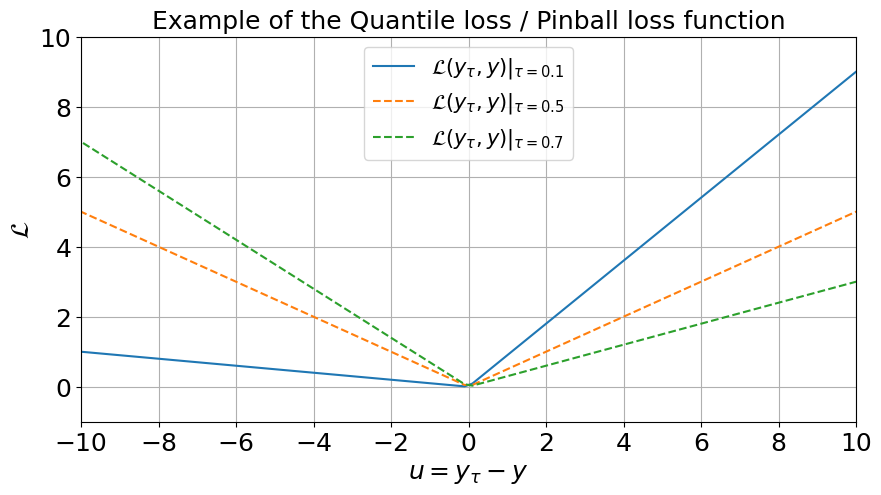

In [6]:
tau=0.1
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]    

loss=(1-tau)*(np.abs(u))
y_larger=u<0
loss[y_larger]=tau*(np.abs(u[y_larger]))

tau_2=0.5
loss_2=(1-tau_2)*(np.abs(u))
loss_2[y_larger]=tau_2*(np.abs(u[y_larger]))

tau_3=0.7
loss_3=(1-tau_3)*(np.abs(u))
loss_3[y_larger]=tau_3*(np.abs(u[y_larger]))

fontsize=18

plt.plot(u,loss)
plt.plot(u,loss_2,'--')
plt.plot(u,loss_3,'--')
plt.rcParams["figure.figsize"] = [10, 5]
plt.grid()
plt.xticks(u_ticks,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlim([-10,10])
plt.ylim([-1,10])
plt.legend([r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.1}$',r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.5}$',r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.7}$'],fontsize=fontsize-3)
plt.xlabel(r"$u=y_{\tau}-y$",fontsize=fontsize)
plt.ylabel(r'$\mathcal{L}$',fontsize=fontsize)
plt.title(r'Example of the Quantile loss / Pinball loss function',fontsize=fontsize)
plt.show()

## Example Quantile Regression Neural Networks (QRNN)

In [7]:
def draw_sample_sin(n_samps, sigma):
    x=np.random.uniform(low=0,high=2*np.pi,size=n_samps)
    noise=np.random.normal(loc=0,scale=sigma,size=n_samps)
    y=np.sin(x)+noise
    return x,y

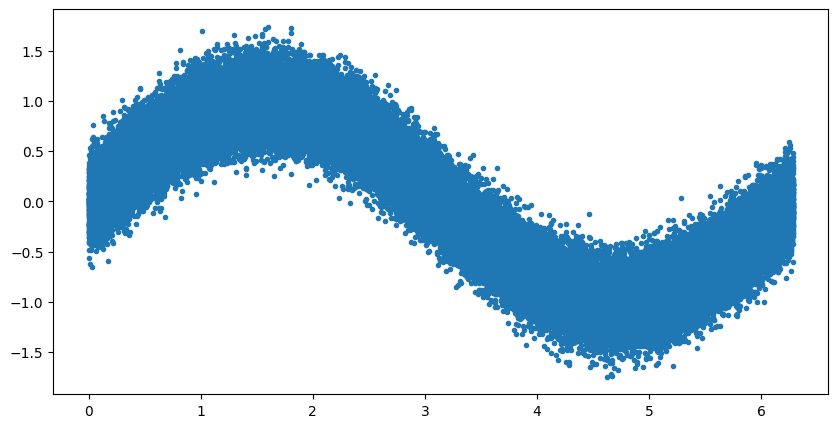

In [8]:
x,y = draw_sample_sin(100000,0.2)
plt.plot(x,y,'.')

In [9]:
x=np.array([x]).T
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.05)


import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train)), int(len(X_train)*val_size)))
train_indices=[i for i in range(len(X_train)) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=500


In [10]:
nepochs=200
quantiles=np.array([0.025,0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95,0.975])
quantiles_01=np.array([0,0.025,0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95,0.975,1])

model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(1,64),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*1) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train,y_train, 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence)

Epoch 1


/home/edgelab/.local/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
Batch number: 100%|██████████| 181/181 [00:00<00:00, 375.20it/s]

Training loss [3.2414181] Validation loss [1.3203889]
----New best validation loss---- [1.3203889]
Epoch 2



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.62it/s]

Training loss [1.2546288] Validation loss [1.1587732]
----New best validation loss---- [1.1587732]
Epoch 3



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.80it/s]

Training loss [1.1206174] Validation loss [1.0472351]
----New best validation loss---- [1.0472351]
Epoch 4



Batch number: 100%|██████████| 181/181 [00:00<00:00, 378.61it/s]

Training loss [1.0249643] Validation loss [0.9632575]
----New best validation loss---- [0.9632575]
Epoch 5



Batch number: 100%|██████████| 181/181 [00:00<00:00, 382.44it/s]

Training loss [0.95173484] Validation loss [0.9007748]
----New best validation loss---- [0.9007748]
Epoch 6



Batch number: 100%|██████████| 181/181 [00:00<00:00, 379.73it/s]

Training loss [0.88586235] Validation loss [0.8359794]
----New best validation loss---- [0.8359794]
Epoch 7



Batch number: 100%|██████████| 181/181 [00:00<00:00, 414.64it/s]

Training loss [0.8260007] Validation loss [0.7871371]
----New best validation loss---- [0.7871371]
Epoch 8



Batch number: 100%|██████████| 181/181 [00:00<00:00, 391.37it/s]

Training loss [0.7798195] Validation loss [0.74463516]
----New best validation loss---- [0.74463516]
Epoch 9



Batch number: 100%|██████████| 181/181 [00:00<00:00, 456.31it/s]

Training loss [0.7465475] Validation loss [0.7205041]
----New best validation loss---- [0.7205041]
Epoch 10



Batch number: 100%|██████████| 181/181 [00:00<00:00, 393.32it/s]

Training loss [0.7250661] Validation loss [0.72498614]
Epoch 11



Batch number: 100%|██████████| 181/181 [00:00<00:00, 594.46it/s]

Training loss [0.71574] Validation loss [0.6940048]
----New best validation loss---- [0.6940048]
Epoch 12



Batch number: 100%|██████████| 181/181 [00:00<00:00, 363.46it/s]

Training loss [0.7059601] Validation loss [0.68994874]


----New best validation loss---- [0.68994874]
Epoch 13


Batch number: 100%|██████████| 181/181 [00:00<00:00, 380.52it/s]

Training loss [0.69890803] Validation loss [0.6834733]
----New best validation loss---- [0.6834733]
Epoch 14



Batch number: 100%|██████████| 181/181 [00:00<00:00, 374.97it/s]

Training loss [0.69472414] Validation loss [0.6827899]
----New best validation loss---- [0.6827899]
Epoch 15



Batch number: 100%|██████████| 181/181 [00:00<00:00, 374.29it/s]

Training loss [0.6914754] Validation loss [0.6764204]
----New best validation loss---- [0.6764204]
Epoch 16



Batch number: 100%|██████████| 181/181 [00:00<00:00, 566.67it/s]

Training loss [0.6891737] Validation loss [0.68325824]
Epoch 17



Batch number: 100%|██████████| 181/181 [00:00<00:00, 563.82it/s]

Training loss [0.6866048] Validation loss [0.67950296]
Epoch 18



Batch number: 100%|██████████| 181/181 [00:00<00:00, 374.67it/s]

Training loss [0.6867189] Validation loss [0.6700377]
----New best validation loss---- [0.6700377]
Epoch 19



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.45it/s]

Training loss [0.68249875] Validation loss [0.67057246]
Epoch 20



Batch number: 100%|██████████| 181/181 [00:00<00:00, 408.39it/s]

Training loss [0.682533] Validation loss [0.66772825]
----New best validation loss---- [0.66772825]
Epoch 21



Batch number: 100%|██████████| 181/181 [00:00<00:00, 375.63it/s]

Training loss [0.68041044] Validation loss [0.67413044]
Epoch 22



Batch number: 100%|██████████| 181/181 [00:00<00:00, 619.89it/s]

Training loss [0.6805171] Validation loss [0.6772442]
Epoch 23



Batch number: 100%|██████████| 181/181 [00:00<00:00, 552.13it/s]

Training loss [0.678327] Validation loss [0.6686932]
Epoch 24



Batch number: 100%|██████████| 181/181 [00:00<00:00, 533.89it/s]

Training loss [0.6784657] Validation loss [0.66787326]
Epoch 25



Batch number: 100%|██████████| 181/181 [00:00<00:00, 586.17it/s]

Training loss [0.6772449] Validation loss [0.6652049]
----New best validation loss---- [0.6652049]
Epoch 26



Batch number: 100%|██████████| 181/181 [00:00<00:00, 461.61it/s]

Training loss [0.6748379] Validation loss [0.6605853]
----New best validation loss---- [0.6605853]
Epoch 27



Batch number: 100%|██████████| 181/181 [00:00<00:00, 613.63it/s]

Training loss [0.6753139] Validation loss [0.65368885]


----New best validation loss---- [0.65368885]
Epoch 28


Batch number: 100%|██████████| 181/181 [00:00<00:00, 569.13it/s]

Training loss [0.6735044] Validation loss [0.66201854]
Epoch 29



Batch number: 100%|██████████| 181/181 [00:00<00:00, 578.13it/s]

Training loss [0.67311215] Validation loss [0.6590798]
Epoch 30



Batch number: 100%|██████████| 181/181 [00:00<00:00, 529.42it/s]

Training loss [0.6726902] Validation loss [0.6686204]
Epoch 31



Batch number: 100%|██████████| 181/181 [00:00<00:00, 370.67it/s]

Training loss [0.6704555] Validation loss [0.65865254]
Epoch 32



Batch number: 100%|██████████| 181/181 [00:00<00:00, 383.20it/s]

Training loss [0.6698984] Validation loss [0.65638155]
Epoch 33



Batch number: 100%|██████████| 181/181 [00:00<00:00, 564.43it/s]

Training loss [0.6697651] Validation loss [0.6613373]
Epoch 34



Batch number: 100%|██████████| 181/181 [00:00<00:00, 556.27it/s]

Training loss [0.6700741] Validation loss [0.65670216]
Epoch 35



Batch number: 100%|██████████| 181/181 [00:00<00:00, 375.10it/s]

Training loss [0.6706978] Validation loss [0.6562605]
Epoch 36



Batch number: 100%|██████████| 181/181 [00:00<00:00, 373.58it/s]

Training loss [0.6684013] Validation loss [0.66009486]
Epoch 37



Batch number: 100%|██████████| 181/181 [00:00<00:00, 373.93it/s]

Training loss [0.6691536] Validation loss [0.64978814]
----New best validation loss---- [0.64978814]
Epoch 38



Batch number: 100%|██████████| 181/181 [00:00<00:00, 368.31it/s]

Training loss [0.66794] Validation loss [0.6600118]
Epoch 39



Batch number: 100%|██████████| 181/181 [00:00<00:00, 619.97it/s]

Training loss [0.6664803] Validation loss [0.64922905]
----New best validation loss---- [0.64922905]
Epoch 40



Batch number: 100%|██████████| 181/181 [00:00<00:00, 413.66it/s]

Training loss [0.6667008] Validation loss [0.6595594]
Epoch 41



Batch number: 100%|██████████| 181/181 [00:00<00:00, 636.88it/s]

Training loss [0.6655742] Validation loss [0.65833354]
Epoch 42



Batch number: 100%|██████████| 181/181 [00:00<00:00, 605.18it/s]


Training loss [0.6666151] Validation loss [0.6524686]
Epoch 43


Batch number: 100%|██████████| 181/181 [00:00<00:00, 567.91it/s]

Training loss [0.6649074] Validation loss [0.6543004]
Epoch 44



Batch number: 100%|██████████| 181/181 [00:00<00:00, 619.42it/s]

Training loss [0.6655024] Validation loss [0.66967326]
Epoch 45



Batch number: 100%|██████████| 181/181 [00:00<00:00, 606.30it/s]


Training loss [0.6635893] Validation loss [0.6508667]
Epoch 46


Batch number: 100%|██████████| 181/181 [00:00<00:00, 593.84it/s]

Training loss [0.66342837] Validation loss [0.6541197]
Epoch 47



Batch number: 100%|██████████| 181/181 [00:00<00:00, 391.04it/s]

Training loss [0.6628356] Validation loss [0.6502997]
Epoch 48



Batch number: 100%|██████████| 181/181 [00:00<00:00, 578.82it/s]

Training loss [0.6632806] Validation loss [0.6545259]
Epoch 49



Batch number: 100%|██████████| 181/181 [00:00<00:00, 657.17it/s]

Training loss [0.6621889] Validation loss [0.6526623]
Epoch 50



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.16it/s]

Training loss [0.6633462] Validation loss [0.66398126]
Epoch 51



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.34it/s]

Training loss [0.6625368] Validation loss [0.6462489]
----New best validation loss---- [0.6462489]
Epoch 52



Batch number: 100%|██████████| 181/181 [00:00<00:00, 612.01it/s]

Training loss [0.66034436] Validation loss [0.65155214]


Epoch 53


Batch number: 100%|██████████| 181/181 [00:00<00:00, 638.66it/s]

Training loss [0.6627442] Validation loss [0.64724284]
Epoch 54



Batch number: 100%|██████████| 181/181 [00:00<00:00, 614.19it/s]

Training loss [0.66130316] Validation loss [0.64786017]
Epoch 55



Batch number: 100%|██████████| 181/181 [00:00<00:00, 368.31it/s]

Training loss [0.66125834] Validation loss [0.6470715]
Epoch 56



Batch number: 100%|██████████| 181/181 [00:00<00:00, 374.74it/s]

Training loss [0.66186106] Validation loss [0.6562568]
Epoch 57



Batch number: 100%|██████████| 181/181 [00:00<00:00, 605.68it/s]


Training loss [0.6620302] Validation loss [0.6451504]
----New best validation loss---- [0.6451504]
Epoch 58


Batch number: 100%|██████████| 181/181 [00:00<00:00, 645.43it/s]

Training loss [0.660647] Validation loss [0.6571534]
Epoch 59



Batch number: 100%|██████████| 181/181 [00:00<00:00, 600.15it/s]

Training loss [0.66030353] Validation loss [0.6444913]
----New best validation loss---- [0.6444913]
Epoch 60



Batch number: 100%|██████████| 181/181 [00:00<00:00, 616.19it/s]

Training loss [0.6601286] Validation loss [0.6425127]


----New best validation loss---- [0.6425127]
Epoch 61


Batch number: 100%|██████████| 181/181 [00:00<00:00, 514.72it/s]

Training loss [0.65992093] Validation loss [0.64803094]
Epoch 62



Batch number: 100%|██████████| 181/181 [00:00<00:00, 585.27it/s]

Training loss [0.66022074] Validation loss [0.65076125]
Epoch 63



Batch number: 100%|██████████| 181/181 [00:00<00:00, 609.67it/s]


Training loss [0.6588943] Validation loss [0.6497998]
Epoch 64


Batch number: 100%|██████████| 181/181 [00:00<00:00, 379.64it/s]

Training loss [0.65973914] Validation loss [0.64605296]
Epoch 65



Batch number: 100%|██████████| 181/181 [00:00<00:00, 404.94it/s]

Training loss [0.65975857] Validation loss [0.64530146]
Epoch 66



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.45it/s]

Training loss [0.65925306] Validation loss [0.6493603]
Epoch 67



Batch number: 100%|██████████| 181/181 [00:00<00:00, 583.25it/s]

Training loss [0.65934736] Validation loss [0.6463123]
Epoch 68



Batch number: 100%|██████████| 181/181 [00:00<00:00, 582.91it/s]

Training loss [0.65997833] Validation loss [0.6490188]
Epoch 69



Batch number: 100%|██████████| 181/181 [00:00<00:00, 565.41it/s]

Training loss [0.65809566] Validation loss [0.66197944]
Epoch 70



Batch number: 100%|██████████| 181/181 [00:00<00:00, 588.27it/s]

Training loss [0.66033316] Validation loss [0.6539591]
Epoch 71



Batch number: 100%|██████████| 181/181 [00:00<00:00, 613.20it/s]

Training loss [0.6589544] Validation loss [0.64708674]


Epoch 72


Batch number: 100%|██████████| 181/181 [00:00<00:00, 605.64it/s]


Training loss [0.6590394] Validation loss [0.64438224]
Epoch 73


Batch number: 100%|██████████| 181/181 [00:00<00:00, 596.22it/s]

Training loss [0.6592708] Validation loss [0.6423983]
----New best validation loss---- [0.6423983]
Epoch 74



Batch number: 100%|██████████| 181/181 [00:00<00:00, 372.68it/s]

Training loss [0.65831643] Validation loss [0.64685327]
Epoch 75



Batch number: 100%|██████████| 181/181 [00:00<00:00, 363.57it/s]


Training loss [0.65853995] Validation loss [0.6692551]
Epoch 76


Batch number: 100%|██████████| 181/181 [00:00<00:00, 402.93it/s]

Training loss [0.6582303] Validation loss [0.658032]
Epoch 77



Batch number: 100%|██████████| 181/181 [00:00<00:00, 374.72it/s]

Training loss [0.6589068] Validation loss [0.6437709]
Epoch 78



Batch number: 100%|██████████| 181/181 [00:00<00:00, 446.12it/s]

Training loss [0.65802646] Validation loss [0.6462449]
Epoch 79



Batch number: 100%|██████████| 181/181 [00:00<00:00, 417.54it/s]

Training loss [0.65788996] Validation loss [0.6435265]
Epoch 80



Batch number: 100%|██████████| 181/181 [00:00<00:00, 438.70it/s]

Training loss [0.65597147] Validation loss [0.65011686]
Epoch 81



Batch number: 100%|██████████| 181/181 [00:00<00:00, 420.62it/s]

Training loss [0.6593721] Validation loss [0.6519597]
Epoch 82



Batch number: 100%|██████████| 181/181 [00:00<00:00, 382.69it/s]

Training loss [0.659088] Validation loss [0.64462686]
Epoch 83



Batch number: 100%|██████████| 181/181 [00:00<00:00, 594.84it/s]

Training loss [0.6573771] Validation loss [0.6416151]
----New best validation loss---- [0.6416151]
Epoch 84



Batch number: 100%|██████████| 181/181 [00:00<00:00, 383.10it/s]

Training loss [0.6578942] Validation loss [0.6471037]
Epoch 85



Batch number: 100%|██████████| 181/181 [00:00<00:00, 416.34it/s]


Training loss [0.65724486] Validation loss [0.645941]
Epoch 86


Batch number: 100%|██████████| 181/181 [00:00<00:00, 430.15it/s]

Training loss [0.6571028] Validation loss [0.65826935]
Epoch 87



Batch number: 100%|██████████| 181/181 [00:00<00:00, 442.01it/s]

Training loss [0.6587141] Validation loss [0.6446699]
Epoch 88



Batch number: 100%|██████████| 181/181 [00:00<00:00, 465.79it/s]

Training loss [0.65778404] Validation loss [0.64972585]
Epoch 89



Batch number: 100%|██████████| 181/181 [00:00<00:00, 435.42it/s]

Training loss [0.6569254] Validation loss [0.66526616]
Epoch 90



Batch number: 100%|██████████| 181/181 [00:00<00:00, 370.46it/s]

Training loss [0.6568647] Validation loss [0.6444242]
Epoch 91



Batch number: 100%|██████████| 181/181 [00:00<00:00, 404.08it/s]

Training loss [0.6574048] Validation loss [0.64502406]
Epoch 92



Batch number: 100%|██████████| 181/181 [00:00<00:00, 554.20it/s]

Training loss [0.6567034] Validation loss [0.65261567]
Epoch 93



Batch number: 100%|██████████| 181/181 [00:00<00:00, 567.18it/s]

Training loss [0.6573459] Validation loss [0.6460715]
Epoch 94



Batch number: 100%|██████████| 181/181 [00:00<00:00, 372.92it/s]

Training loss [0.65639126] Validation loss [0.64705354]
Epoch 95



Batch number: 100%|██████████| 181/181 [00:00<00:00, 649.33it/s]

Training loss [0.65814036] Validation loss [0.63885605]
----New best validation loss---- [0.63885605]
Epoch 96



Batch number: 100%|██████████| 181/181 [00:00<00:00, 402.60it/s]

Training loss [0.6569152] Validation loss [0.63890684]
Epoch 97



Batch number: 100%|██████████| 181/181 [00:00<00:00, 433.64it/s]

Training loss [0.6562426] Validation loss [0.6467853]
Epoch 98



Batch number: 100%|██████████| 181/181 [00:00<00:00, 374.88it/s]

Training loss [0.6579107] Validation loss [0.6541444]
Epoch 99



Batch number: 100%|██████████| 181/181 [00:00<00:00, 444.84it/s]

Training loss [0.65761936] Validation loss [0.6487986]
Epoch 100



Batch number: 100%|██████████| 181/181 [00:00<00:00, 654.37it/s]

Training loss [0.65532434] Validation loss [0.64664924]
Epoch 101



Batch number: 100%|██████████| 181/181 [00:00<00:00, 552.68it/s]

Training loss [0.65888804] Validation loss [0.64331734]
Epoch 102



Batch number: 100%|██████████| 181/181 [00:00<00:00, 615.12it/s]

Training loss [0.6579237] Validation loss [0.6506975]


Epoch 103


Batch number: 100%|██████████| 181/181 [00:00<00:00, 490.35it/s]

Training loss [0.6565127] Validation loss [0.64229214]
Epoch 104



Batch number: 100%|██████████| 181/181 [00:00<00:00, 371.31it/s]

Training loss [0.6573049] Validation loss [0.6442069]
Epoch 105



Batch number: 100%|██████████| 181/181 [00:00<00:00, 435.14it/s]

Training loss [0.6562112] Validation loss [0.6395744]
Epoch 106



Batch number: 100%|██████████| 181/181 [00:00<00:00, 371.89it/s]

Training loss [0.6572731] Validation loss [0.6577591]
Epoch 107



Batch number: 100%|██████████| 181/181 [00:00<00:00, 411.75it/s]

Training loss [0.6567559] Validation loss [0.64340556]


Epoch 108


Batch number: 100%|██████████| 181/181 [00:00<00:00, 422.13it/s]

Training loss [0.6563846] Validation loss [0.6466965]
Epoch 109



Batch number: 100%|██████████| 181/181 [00:00<00:00, 542.95it/s]

Training loss [0.65776634] Validation loss [0.6506234]
Epoch 110



Batch number: 100%|██████████| 181/181 [00:00<00:00, 484.48it/s]

Training loss [0.6573983] Validation loss [0.6423275]
Epoch 111



Batch number: 100%|██████████| 181/181 [00:00<00:00, 547.95it/s]

Training loss [0.6559747] Validation loss [0.65263164]
Epoch 112



Batch number: 100%|██████████| 181/181 [00:00<00:00, 501.24it/s]

Training loss [0.65732855] Validation loss [0.6488576]
Epoch 113



Batch number: 100%|██████████| 181/181 [00:00<00:00, 457.63it/s]

Training loss [0.6562523] Validation loss [0.6454819]
Epoch 114



Batch number: 100%|██████████| 181/181 [00:00<00:00, 536.88it/s]

Training loss [0.65678] Validation loss [0.6408985]
Epoch 115



Batch number: 100%|██████████| 181/181 [00:00<00:00, 568.63it/s]

Training loss [0.6588606] Validation loss [0.6451311]
Epoch 116



Batch number: 100%|██████████| 181/181 [00:00<00:00, 565.59it/s]

Training loss [0.6565257] Validation loss [0.6507458]
Epoch 117



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.82it/s]

Training loss [0.6584325] Validation loss [0.65541476]
Epoch 118



Batch number: 100%|██████████| 181/181 [00:00<00:00, 603.68it/s]


Training loss [0.6559259] Validation loss [0.64072174]
Epoch 119


Batch number: 100%|██████████| 181/181 [00:00<00:00, 593.61it/s]

Training loss [0.655868] Validation loss [0.6432565]
Epoch 120



Batch number: 100%|██████████| 181/181 [00:00<00:00, 635.28it/s]

Training loss [0.65765756] Validation loss [0.64408153]
Epoch 121



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.26it/s]

Training loss [0.65522325] Validation loss [0.6458457]
Epoch 122



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.29it/s]

Training loss [0.6565114] Validation loss [0.64176184]
Epoch 123



Batch number: 100%|██████████| 181/181 [00:00<00:00, 578.29it/s]

Training loss [0.655574] Validation loss [0.65062547]
Epoch 124



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.34it/s]

Training loss [0.6576948] Validation loss [0.65513515]
Epoch 125



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.39it/s]

Training loss [0.6567119] Validation loss [0.6441978]
Epoch 126



Batch number: 100%|██████████| 181/181 [00:00<00:00, 569.53it/s]

Training loss [0.6558963] Validation loss [0.64349097]
Epoch 127



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.05it/s]

Training loss [0.6564827] Validation loss [0.64877135]
Epoch 128



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.77it/s]

Training loss [0.65704757] Validation loss [0.64098155]
Epoch 129



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.53it/s]

Training loss [0.656312] Validation loss [0.6523831]
Epoch 130



Batch number: 100%|██████████| 181/181 [00:00<00:00, 566.46it/s]

Training loss [0.65542936] Validation loss [0.65609854]
Epoch 131



Batch number: 100%|██████████| 181/181 [00:00<00:00, 569.90it/s]

Training loss [0.6565143] Validation loss [0.64769363]
Epoch 132



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.22it/s]

Training loss [0.65682703] Validation loss [0.64279747]
Epoch 133



Batch number: 100%|██████████| 181/181 [00:00<00:00, 374.25it/s]

Training loss [0.6559007] Validation loss [0.6414897]
Epoch 134



Batch number: 100%|██████████| 181/181 [00:00<00:00, 379.89it/s]

Training loss [0.65778214] Validation loss [0.65293187]
Epoch 135



Batch number: 100%|██████████| 181/181 [00:00<00:00, 378.35it/s]

Training loss [0.6571163] Validation loss [0.6464665]
Epoch 136



Batch number: 100%|██████████| 181/181 [00:00<00:00, 377.43it/s]

Training loss [0.65736115] Validation loss [0.64540905]
Epoch 137



Batch number: 100%|██████████| 181/181 [00:00<00:00, 375.63it/s]

Training loss [0.6557623] Validation loss [0.65212226]
Epoch 138



Batch number: 100%|██████████| 181/181 [00:00<00:00, 381.77it/s]

Training loss [0.6566129] Validation loss [0.6442837]
Epoch 139



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.71it/s]

Training loss [0.65683395] Validation loss [0.6479292]
Epoch 140



Batch number: 100%|██████████| 181/181 [00:00<00:00, 605.19it/s]


Training loss [0.6557638] Validation loss [0.6443311]
Epoch 141


Batch number: 100%|██████████| 181/181 [00:00<00:00, 363.28it/s]

Training loss [0.6555509] Validation loss [0.6473768]


Epoch 142


Batch number: 100%|██████████| 181/181 [00:00<00:00, 588.61it/s]

Training loss [0.6561216] Validation loss [0.6483803]
Epoch 143



Batch number: 100%|██████████| 181/181 [00:00<00:00, 607.01it/s]


Training loss [0.65740573] Validation loss [0.6506031]
Epoch 144


Batch number: 100%|██████████| 181/181 [00:00<00:00, 583.09it/s]

Training loss [0.6560777] Validation loss [0.6480727]
Epoch 145



Batch number: 100%|██████████| 181/181 [00:00<00:00, 399.06it/s]

Training loss [0.6561879] Validation loss [0.65501285]
Epoch 146



Batch number: 100%|██████████| 181/181 [00:00<00:00, 594.62it/s]

Training loss [0.65685695] Validation loss [0.648005]
Epoch 147



Batch number: 100%|██████████| 181/181 [00:00<00:00, 625.81it/s]

Training loss [0.65631574] Validation loss [0.6463938]
Epoch 148



Batch number: 100%|██████████| 181/181 [00:00<00:00, 389.39it/s]

Training loss [0.65798897] Validation loss [0.6459028]
Epoch 149



Batch number: 100%|██████████| 181/181 [00:00<00:00, 584.16it/s]

Training loss [0.65628177] Validation loss [0.6496612]
Epoch 150



Batch number: 100%|██████████| 181/181 [00:00<00:00, 596.18it/s]

Training loss [0.6559229] Validation loss [0.6550817]
Epoch 151



Batch number: 100%|██████████| 181/181 [00:00<00:00, 582.83it/s]

Training loss [0.65673715] Validation loss [0.6433201]
Epoch 152



Batch number: 100%|██████████| 181/181 [00:00<00:00, 618.48it/s]

Training loss [0.65608317] Validation loss [0.6539349]
Epoch 153



Batch number: 100%|██████████| 181/181 [00:00<00:00, 600.97it/s]

Training loss [0.6544292] Validation loss [0.634228]
----New best validation loss---- [0.634228]
Epoch 154



Batch number: 100%|██████████| 181/181 [00:00<00:00, 373.93it/s]

Training loss [0.65679485] Validation loss [0.65418845]
Epoch 155



Batch number: 100%|██████████| 181/181 [00:00<00:00, 364.47it/s]

Training loss [0.657447] Validation loss [0.6503716]
Epoch 156



Batch number: 100%|██████████| 181/181 [00:00<00:00, 602.91it/s]


Training loss [0.6571514] Validation loss [0.6476584]
Epoch 157


Batch number: 100%|██████████| 181/181 [00:00<00:00, 398.92it/s]

Training loss [0.6569088] Validation loss [0.6402859]
Epoch 158



Batch number: 100%|██████████| 181/181 [00:00<00:00, 365.72it/s]

Training loss [0.65536064] Validation loss [0.64608794]
Epoch 159



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.18it/s]

Training loss [0.6562875] Validation loss [0.65520746]
Epoch 160



Batch number: 100%|██████████| 181/181 [00:00<00:00, 623.93it/s]

Training loss [0.65574545] Validation loss [0.6409971]
Epoch 161



Batch number: 100%|██████████| 181/181 [00:00<00:00, 637.53it/s]

Training loss [0.65655524] Validation loss [0.64632255]
Epoch 162



Batch number: 100%|██████████| 181/181 [00:00<00:00, 366.37it/s]

Training loss [0.6553616] Validation loss [0.64096856]
Epoch 163



Batch number: 100%|██████████| 181/181 [00:00<00:00, 678.30it/s]

Training loss [0.65768135] Validation loss [0.64831287]
Epoch 164



Batch number: 100%|██████████| 181/181 [00:00<00:00, 642.75it/s]

Training loss [0.6572739] Validation loss [0.64901865]
Epoch 165



Batch number: 100%|██████████| 181/181 [00:00<00:00, 642.45it/s]

Training loss [0.6551639] Validation loss [0.65031046]
Epoch 166



Batch number: 100%|██████████| 181/181 [00:00<00:00, 585.69it/s]

Training loss [0.65731096] Validation loss [0.641703]
Epoch 167



Batch number: 100%|██████████| 181/181 [00:00<00:00, 383.59it/s]

Training loss [0.65635526] Validation loss [0.64629495]
Epoch 168



Batch number: 100%|██████████| 181/181 [00:00<00:00, 610.88it/s]


Training loss [0.65729344] Validation loss [0.6461017]
Epoch 169


Batch number: 100%|██████████| 181/181 [00:00<00:00, 606.81it/s]


Training loss [0.65582734] Validation loss [0.6471902]
Epoch 170


Batch number: 100%|██████████| 181/181 [00:00<00:00, 372.78it/s]

Training loss [0.6560822] Validation loss [0.6438173]
Epoch 171



Batch number: 100%|██████████| 181/181 [00:00<00:00, 636.03it/s]

Training loss [0.6560848] Validation loss [0.64257973]
Epoch 172



Batch number: 100%|██████████| 181/181 [00:00<00:00, 597.23it/s]

Training loss [0.65790486] Validation loss [0.6478611]
Epoch 173



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.60it/s]

Training loss [0.6550276] Validation loss [0.64622504]
Epoch 174



Batch number: 100%|██████████| 181/181 [00:00<00:00, 648.93it/s]

Training loss [0.6571468] Validation loss [0.64513266]
Epoch 175



Batch number: 100%|██████████| 181/181 [00:00<00:00, 617.74it/s]

Training loss [0.6556872] Validation loss [0.64006925]
Epoch 176



Batch number: 100%|██████████| 181/181 [00:00<00:00, 597.05it/s]

Training loss [0.65676534] Validation loss [0.64397436]
Epoch 177



Batch number: 100%|██████████| 181/181 [00:00<00:00, 578.53it/s]

Training loss [0.65747344] Validation loss [0.65078515]
Epoch 178



Batch number: 100%|██████████| 181/181 [00:00<00:00, 609.18it/s]


Training loss [0.65636796] Validation loss [0.64774764]
Epoch 179


Batch number: 100%|██████████| 181/181 [00:00<00:00, 579.22it/s]

Training loss [0.65593356] Validation loss [0.6463265]
Epoch 180



Batch number: 100%|██████████| 181/181 [00:00<00:00, 612.56it/s]

Training loss [0.6575796] Validation loss [0.6472609]


Epoch 181


Batch number: 100%|██████████| 181/181 [00:00<00:00, 602.77it/s]

Training loss [0.65482116] Validation loss [0.6460749]
Epoch 182



Batch number: 100%|██████████| 181/181 [00:00<00:00, 695.22it/s]

Training loss [0.6574113] Validation loss [0.6471497]
Epoch 183



Batch number: 100%|██████████| 181/181 [00:00<00:00, 591.04it/s]

Training loss [0.65621954] Validation loss [0.64053243]
Epoch 184



Batch number: 100%|██████████| 181/181 [00:00<00:00, 597.10it/s]

Training loss [0.65706056] Validation loss [0.6476111]
Epoch 185



Batch number: 100%|██████████| 181/181 [00:00<00:00, 604.92it/s]


Training loss [0.6570218] Validation loss [0.6452623]
Epoch 186


Batch number: 100%|██████████| 181/181 [00:00<00:00, 604.10it/s]


Training loss [0.65752363] Validation loss [0.6408939]
Epoch 187


Batch number: 100%|██████████| 181/181 [00:00<00:00, 608.61it/s]


Training loss [0.65432835] Validation loss [0.64420134]
Epoch 188


Batch number: 100%|██████████| 181/181 [00:00<00:00, 578.38it/s]

Training loss [0.6559403] Validation loss [0.6501847]
Epoch 189



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.20it/s]

Training loss [0.65604436] Validation loss [0.6471179]
Epoch 190



Batch number: 100%|██████████| 181/181 [00:00<00:00, 640.58it/s]

Training loss [0.65526897] Validation loss [0.6517813]
Epoch 191



Batch number: 100%|██████████| 181/181 [00:00<00:00, 655.38it/s]

Training loss [0.65606636] Validation loss [0.6459329]
Epoch 192



Batch number: 100%|██████████| 181/181 [00:00<00:00, 625.54it/s]

Training loss [0.6561941] Validation loss [0.64055103]
Epoch 193



Batch number: 100%|██████████| 181/181 [00:00<00:00, 599.98it/s]

Training loss [0.65574014] Validation loss [0.645981]
Epoch 194



Batch number: 100%|██████████| 181/181 [00:00<00:00, 612.12it/s]


Training loss [0.6578268] Validation loss [0.64342344]
Epoch 195


Batch number: 100%|██████████| 181/181 [00:00<00:00, 600.39it/s]

Training loss [0.65765864] Validation loss [0.6514839]
Epoch 196



Batch number: 100%|██████████| 181/181 [00:00<00:00, 596.95it/s]

Training loss [0.65486383] Validation loss [0.643435]
Epoch 197



Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.67it/s]

Training loss [0.65520597] Validation loss [0.65551126]
Epoch 198



Batch number: 100%|██████████| 181/181 [00:00<00:00, 568.43it/s]

Training loss [0.65732026] Validation loss [0.6507612]
Epoch 199



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.29it/s]

Training loss [0.6565841] Validation loss [0.64262235]
Epoch 200



Batch number: 100%|██████████| 181/181 [00:00<00:00, 568.86it/s]

Training loss [0.6544527] Validation loss [0.6527183]
Best model out of total max epochs found at epoch 153


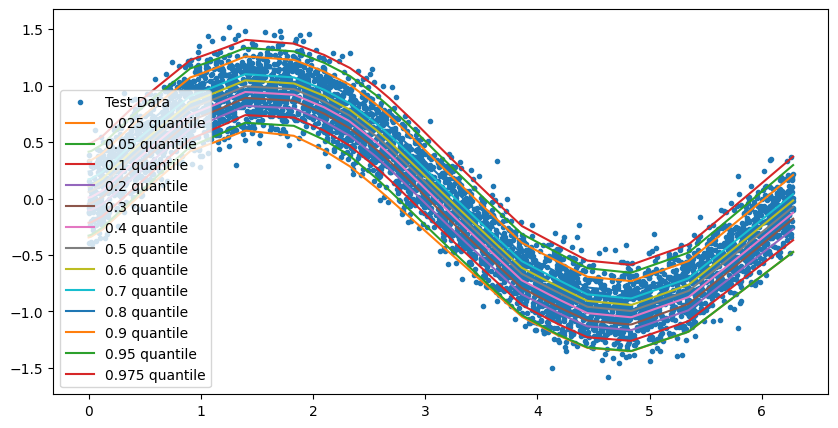

In [11]:
sort_indices=np.argsort(X_test[:,0])
X_test_sort=X_test[sort_indices]
y_test_sort=y_test[sort_indices]
preds = model.predict(X_test_sort)

plt.plot(X_test_sort,y_test_sort,'.')
plt.plot(X_test_sort,preds)

legend=["Test Data"]
quantiles_str=[str(quant)+" quantile" for quant in quantiles]
legend.extend(quantiles_str)
plt.legend(legend)
plt.show()

In [12]:
QuantileNetwork.quant_rate(y_test_sort,preds)

array([0.0234, 0.0358, 0.087 , 0.1942, 0.2872, 0.4046, 0.5084, 0.6134,
       0.714 , 0.8066, 0.909 , 0.9584, 0.9812])

In [13]:
def cdf(pred, x, quantiles):
    r"""
    Approximate the posterior CDF for given inputs x.

    Propagates the inputs in x forward through the network and
    approximates the posterior CDF by a piecewise linear function.

    The piecewise linear function is given by its values at approximate
    quantiles :math:`x_\tau`` for :math:`\tau = \{0.0, \tau_1, \ldots,
    \tau_k, 1.0\}` where :math:`\tau_k` are the quantiles to be estimated
    by the network. The values for :math:`x_{0.0}` and :math:`x_{1.0}` are
    computed using

    .. math::

        x_{0.0} = 2.0 x_{\tau_1} - x_{\tau_2}

        x_{1.0} = 2.0 x_{\tau_k} - x_{\tau_{k-1}}

    Arguments:

        x(np.array): Array of shape (n, m) containing n inputs for which
                        to predict the conditional quantiles.

    Returns:

        Tuple (xs, fs) containing the :math:`x`-values in xs and corresponding
        values of the posterior CDF :math:`F(x)` in fs.

    """
    if len(x.shape) > 1:
        s = x.shape[:-1] + (len(quantiles) + 2,)
    else:
        s = (1, len(quantiles) + 2)

    y_pred = np.zeros(s)
    y_pred[:, 1:-1] = pred
    y_pred[:, 0] = 2.0 * y_pred[:, 1] - y_pred[:, 2]
    y_pred[:, -1] = 2.0 * y_pred[:, -2] - y_pred[:, -3]

    qs = np.zeros(len(quantiles) + 2)
    qs[1:-1] = quantiles
    qs[0] = 0.0
    qs[-1] = 1.0

    return y_pred, qs

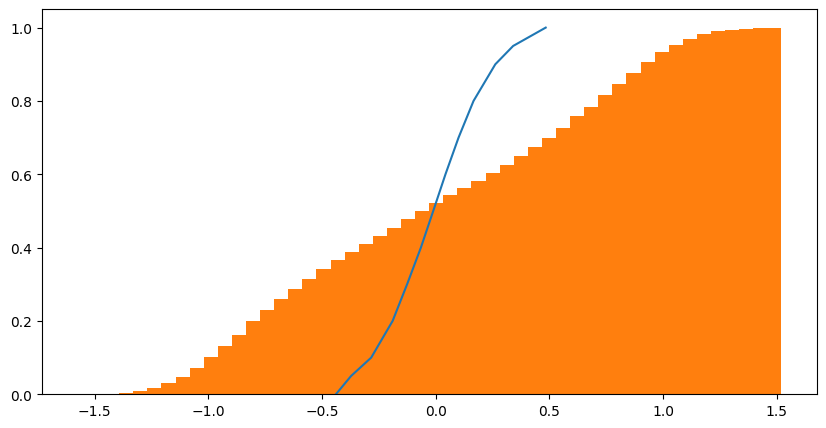

In [14]:
x_cdf, y_cdf = cdf(preds,X_test_sort,quantiles)

plt.plot(np.mean(x_cdf,axis=0),y_cdf)
plt.hist(y_test,cumulative=True, density=True,bins=50)
plt.show()

In [15]:
index_median=6
example_cdf_ix=1
b=4

In [16]:
m=np.abs(preds[:,index_median]-y_test[:])
m_isort=np.argsort(m)
pred_y_post_s=preds[m_isort,:]
y_post_s=y_test[m_isort]
X_post_s=X_test[m_isort]

In [17]:
example_cdf=pred_y_post_s[example_cdf_ix,:]
example_cdf_01=np.zeros(len(quantiles_01))
example_cdf_01[1:-1]=example_cdf
example_cdf_01[-1]=2.0 * example_cdf[-1] -example_cdf[-2]
example_cdf_01[0]= 2.0 * example_cdf[0] -example_cdf[1]
    

example_pdf=(quantiles_01[1:]-quantiles_01[:-1])/(example_cdf_01[1:]-example_cdf_01[:-1])
example_pdf_x=(example_cdf_01[1:]+example_cdf_01[:-1])/2
example_pdf_x_extra=np.zeros(len(example_pdf_x)+2)

example_pdf_x_extra[1:-1]=example_pdf_x
example_pdf_x_extra[0]=example_pdf_x[0]
example_pdf_x_extra[-1]=example_pdf_x[-1]

example_pdf_extra=np.zeros(len(example_pdf)+2)
example_pdf_extra[1:-1]=example_pdf
example_pdf_extra[0]=0
example_pdf_extra[-1]=0

(-0.6790909051895142, 0.3598478317260742)

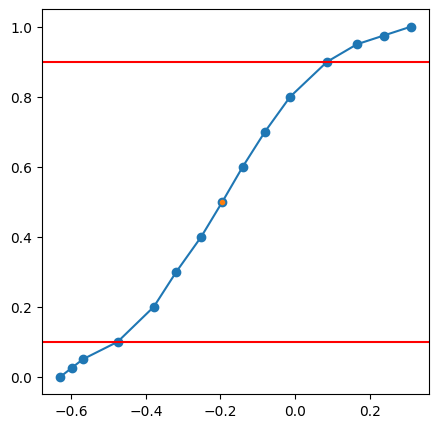

In [18]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.plot(example_cdf_01,quantiles_01,'-o')
plt.plot(y_post_s[example_cdf_ix],0.5,'.')
plt.hlines(0.1,xmin=-1,xmax=1,colors='r')
plt.hlines(0.9,xmin=-1,xmax=1,colors='r')
plt.xlim(np.min(example_cdf_01)-0.05,np.max(example_cdf_01)+0.05)

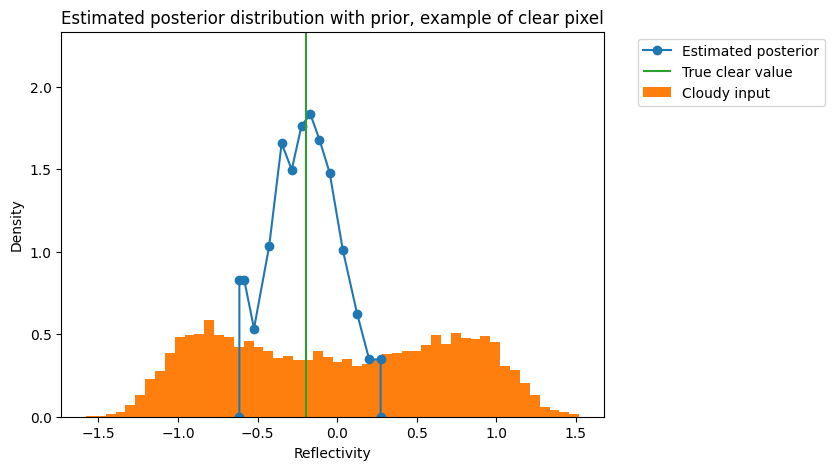

In [19]:
plt.rcParams["figure.figsize"] = [7, 5]
plt.plot(example_pdf_x_extra,example_pdf_extra,'-o')
plt.hist(y_test,density=True,bins=50)
plt.vlines(y_post_s[example_cdf_ix],ymin=0,ymax=np.max(example_pdf)+10,colors='tab:green')
#plt.vlines(X_post_s[example_cdf_ix],ymin=0,ymax=np.max(example_pdf)+10,colors='tab:pink')
plt.ylim([0,np.max(example_pdf)+0.5])
plt.legend(['Estimated posterior','True clear value','Cloudy input','Prior distribution'],bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Estimated posterior distribution with prior, example of clear pixel')
plt.ylabel('Density')
plt.xlabel('Reflectivity')
plt.show()

## Example Quantiles

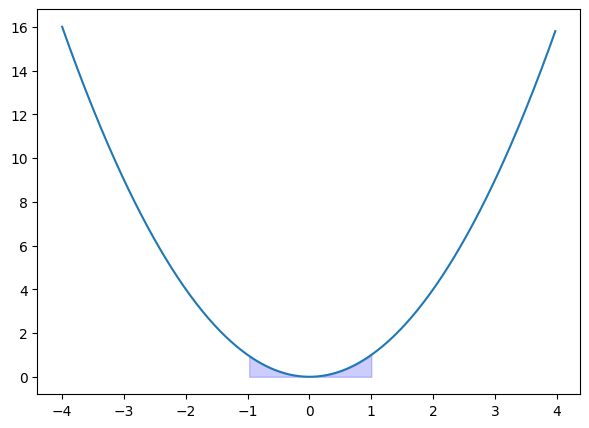

In [20]:
import numpy as np
from matplotlib import pyplot as plt

def f(t):
    return t * t

t = np.arange(-4,4,1/40)

#Print the curve
plt.plot(t,f(t))

#Fill under the curve
plt.fill_between(
        x= t, 
        y1= f(t), 
        where= (-1 < t)&(t < 1),
        color= "b",
        alpha= 0.2)
        
plt.show()

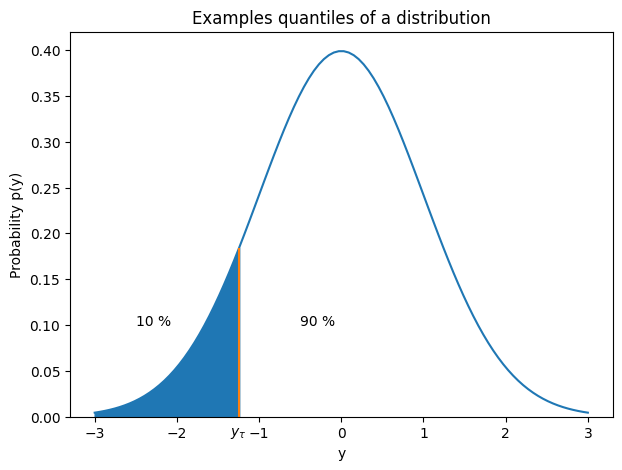

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pdf=stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf)
plt.vlines(x[29],ymin=-1,ymax=pdf[29],colors='tab:orange')
plt.fill_between(
        x= x, 
        y1= pdf, 
        where= (x[29] >= x)&(x >= -3),
        color= "tab:blue",
        alpha= 1)
plt.ylim([0,0.42])
plt.title('Examples quantiles of a distribution')
plt.annotate(r'10 %',xy=[-2.5,0.10])
plt.annotate(r'90 %',xy=[-0.5,0.10])
plt.ylabel('Probability p(y)')
plt.xlabel('y')
plt.text(-1.35,-0.02,r'$y_\tau$')
plt.show()

In [38]:
x[50]

0.030303030303030276

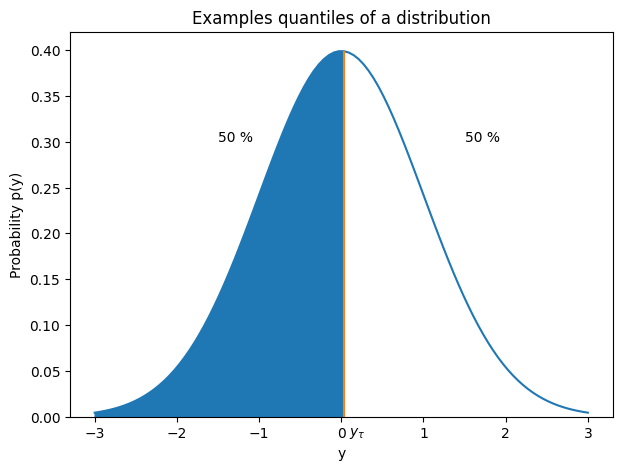

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pdf=stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf)
plt.vlines(x[50],ymin=-1,ymax=pdf[50],colors='tab:orange')
plt.fill_between(
        x= x, 
        y1= pdf, 
        where= (x[50] >= x)&(x >= -3),
        color= "tab:blue",
        alpha= 1)
plt.ylim([0,0.42])
plt.title('Examples quantiles of a distribution')
plt.annotate(r'50 %',xy=[-1.5,0.30])
plt.annotate(r'50 %',xy=[1.5,0.30])
plt.ylabel('Probability p(y)')
plt.xlabel('y')
plt.text(0.1,-0.02,r'$y_\tau$')
plt.show()

In [22]:
(x[29] < x)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [23]:
x[29]

-1.2424242424242424

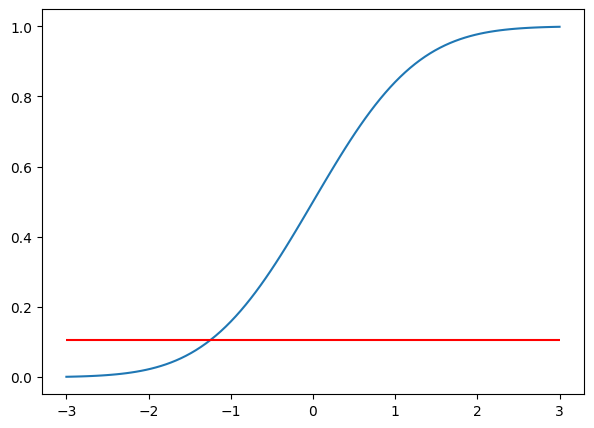

In [24]:
cdf=stats.norm.cdf(x, mu, sigma)
plt.plot(x, cdf)
plt.hlines(cdf[29],xmin=-3,xmax=3,colors='r')
plt.show()

In [25]:
cdf[29]

0.10704003789347644